In [1]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from scipy.stats.mstats import winsorize

import matplotlib.pyplot as plt
import missingno as msno

import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.metrics import mean_squared_error, make_scorer, classification_report

from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/kaggle/input/playground-series-s3e20/sample_submission.csv
/kaggle/input/playground-series-s3e20/train.csv
/kaggle/input/playground-series-s3e20/test.csv


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sample_submission=pd.read_csv('/kaggle/input/playground-series-s3e20/sample_submission.csv')
train=pd.read_csv('/kaggle/input/playground-series-s3e20/train.csv')
test=pd.read_csv('/kaggle/input/playground-series-s3e20/test.csv')

In [3]:
train.isnull().sum()

ID_LAT_LON_YEAR_WEEK            0
latitude                        0
longitude                       0
year                            0
week_no                         0
                             ... 
Cloud_sensor_azimuth_angle    484
Cloud_sensor_zenith_angle     484
Cloud_solar_azimuth_angle     484
Cloud_solar_zenith_angle      484
emission                        0
Length: 76, dtype: int64

In [4]:
[i for i in train.columns if train[i].isnull().sum()]

['SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_column_number_density_amf',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_cloud_fraction',
 'SulphurDioxide_sensor_azimuth_angle',
 'SulphurDioxide_sensor_zenith_angle',
 'SulphurDioxide_solar_azimuth_angle',
 'SulphurDioxide_solar_zenith_angle',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'CarbonMonoxide_H2O_column_number_density',
 'CarbonMonoxide_cloud_height',
 'CarbonMonoxide_sensor_altitude',
 'CarbonMonoxide_sensor_azimuth_angle',
 'CarbonMonoxide_sensor_zenith_angle',
 'CarbonMonoxide_solar_azimuth_angle',
 'CarbonMonoxide_solar_zenith_angle',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'NitrogenDioxide_tropopause_pressure',
 'NitrogenDioxide_absorbing_aerosol_index',
 '

In [5]:
fig = px.scatter_mapbox(
    train,
    lat="latitude",
    lon="longitude",
    size="emission",
    color="emission",
    color_continuous_scale='Viridis',
    size_max=20,
    zoom=6
)

fig.update_layout(mapbox_style="open-street-map")

fig.update_layout(
    title="Emission Data Map Visualization",
    margin={"r": 0, "t": 30, "l": 0, "b": 0},
)

fig.show()

In [7]:
fig = px.scatter_3d(train, x='latitude', y='longitude', z='emission',
              color='emission')
fig.show()

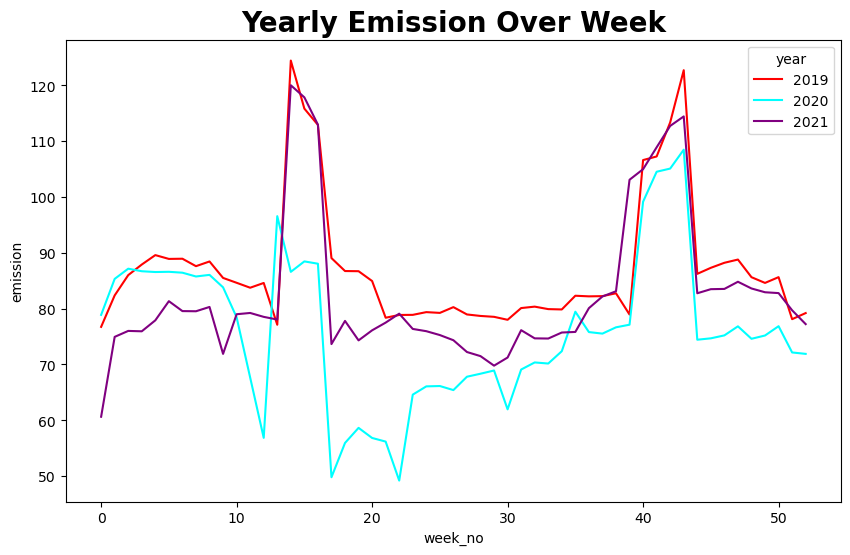

In [8]:
plt.figure(figsize=(10, 6))


sns.lineplot(
    data = train[['year',  'week_no', 'emission']].groupby(['year', 'week_no'])['emission'].mean().reset_index(), 
    x = 'week_no', 
    y = 'emission',
    hue='year',
    palette=["red", "cyan", "purple"], 
    errorbar = None
)
    
plt.title('Yearly Emission Over Week', fontsize = 20, fontweight = 'bold')
plt.show()

/tmp/ipykernel_28/4269826936.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



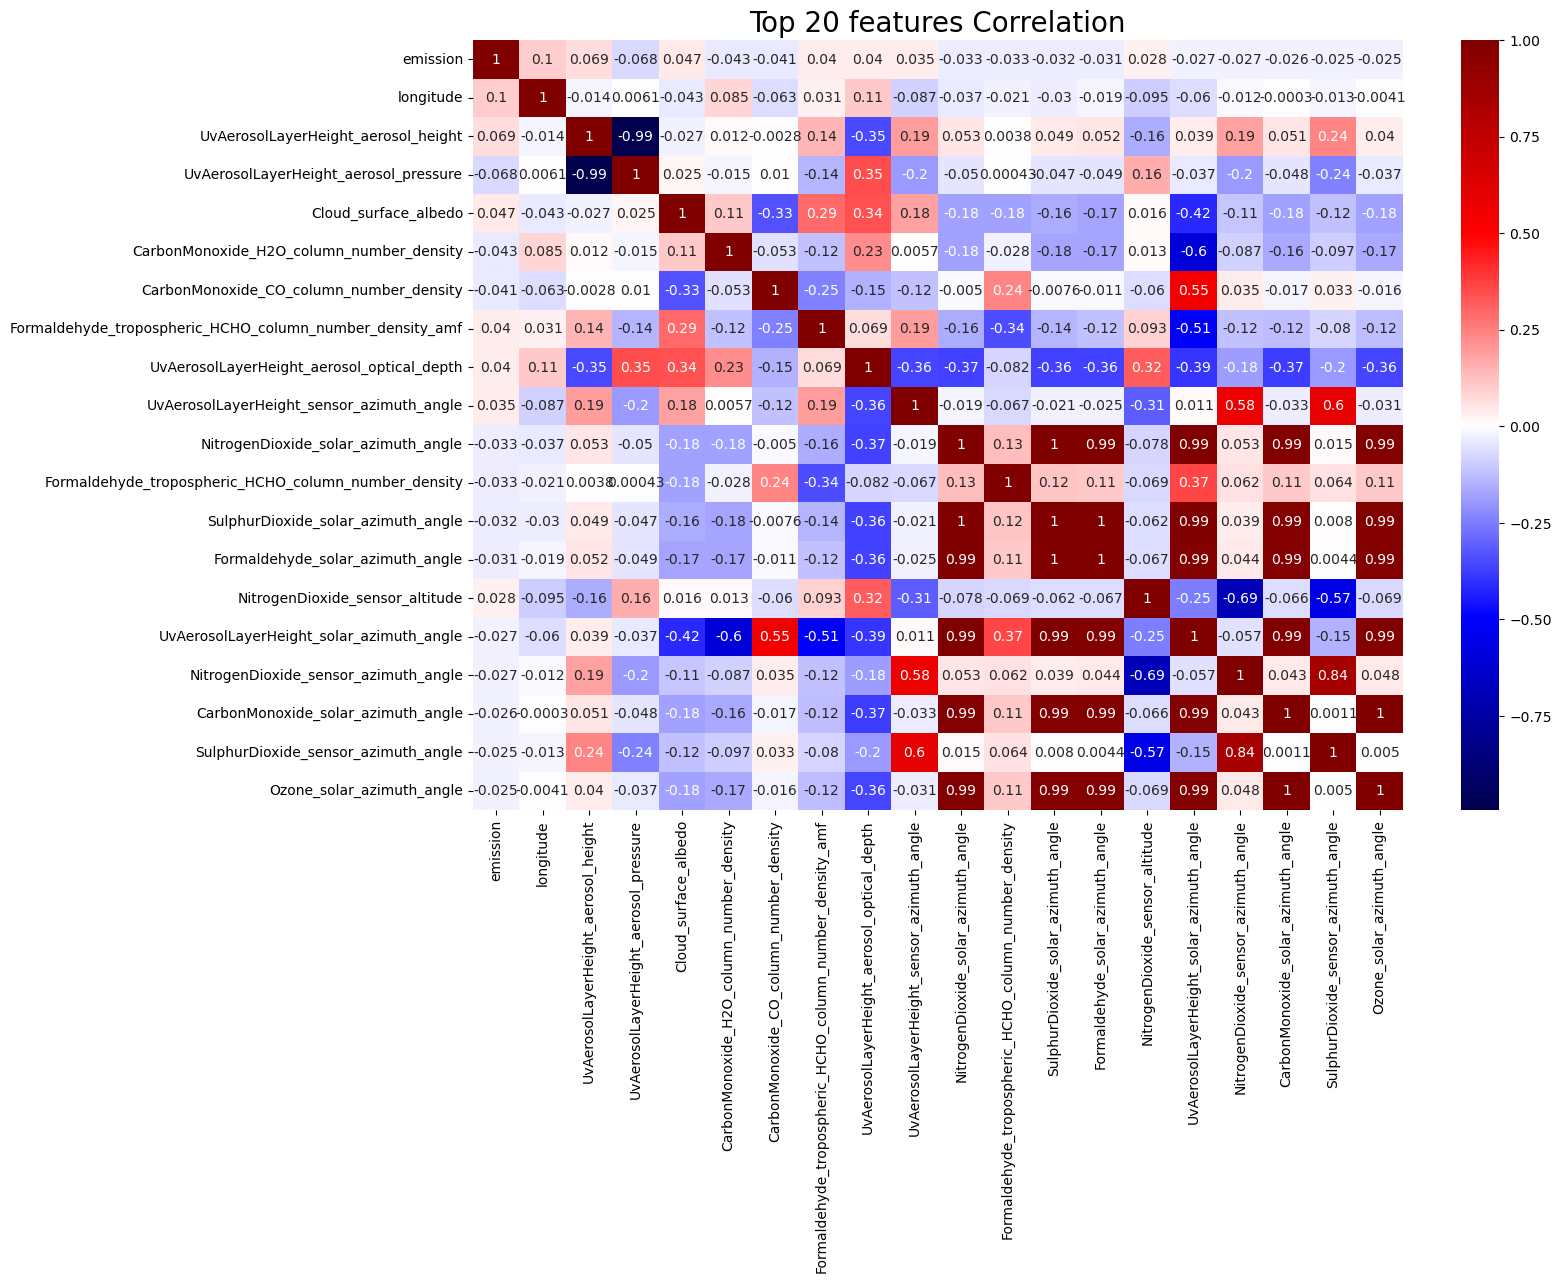

In [11]:
top20_corrs = abs(train.corr()['emission']).sort_values(ascending = False).head(20)

corr = train[list(top20_corrs.index)].corr()
plt.figure(figsize = (15, 10))
sns.heatmap(corr, cmap='seismic', annot = True, center = 0)
plt.title('Top 20 features Correlation', fontsize = 20, color = 'black')
plt.show()

<Axes: >

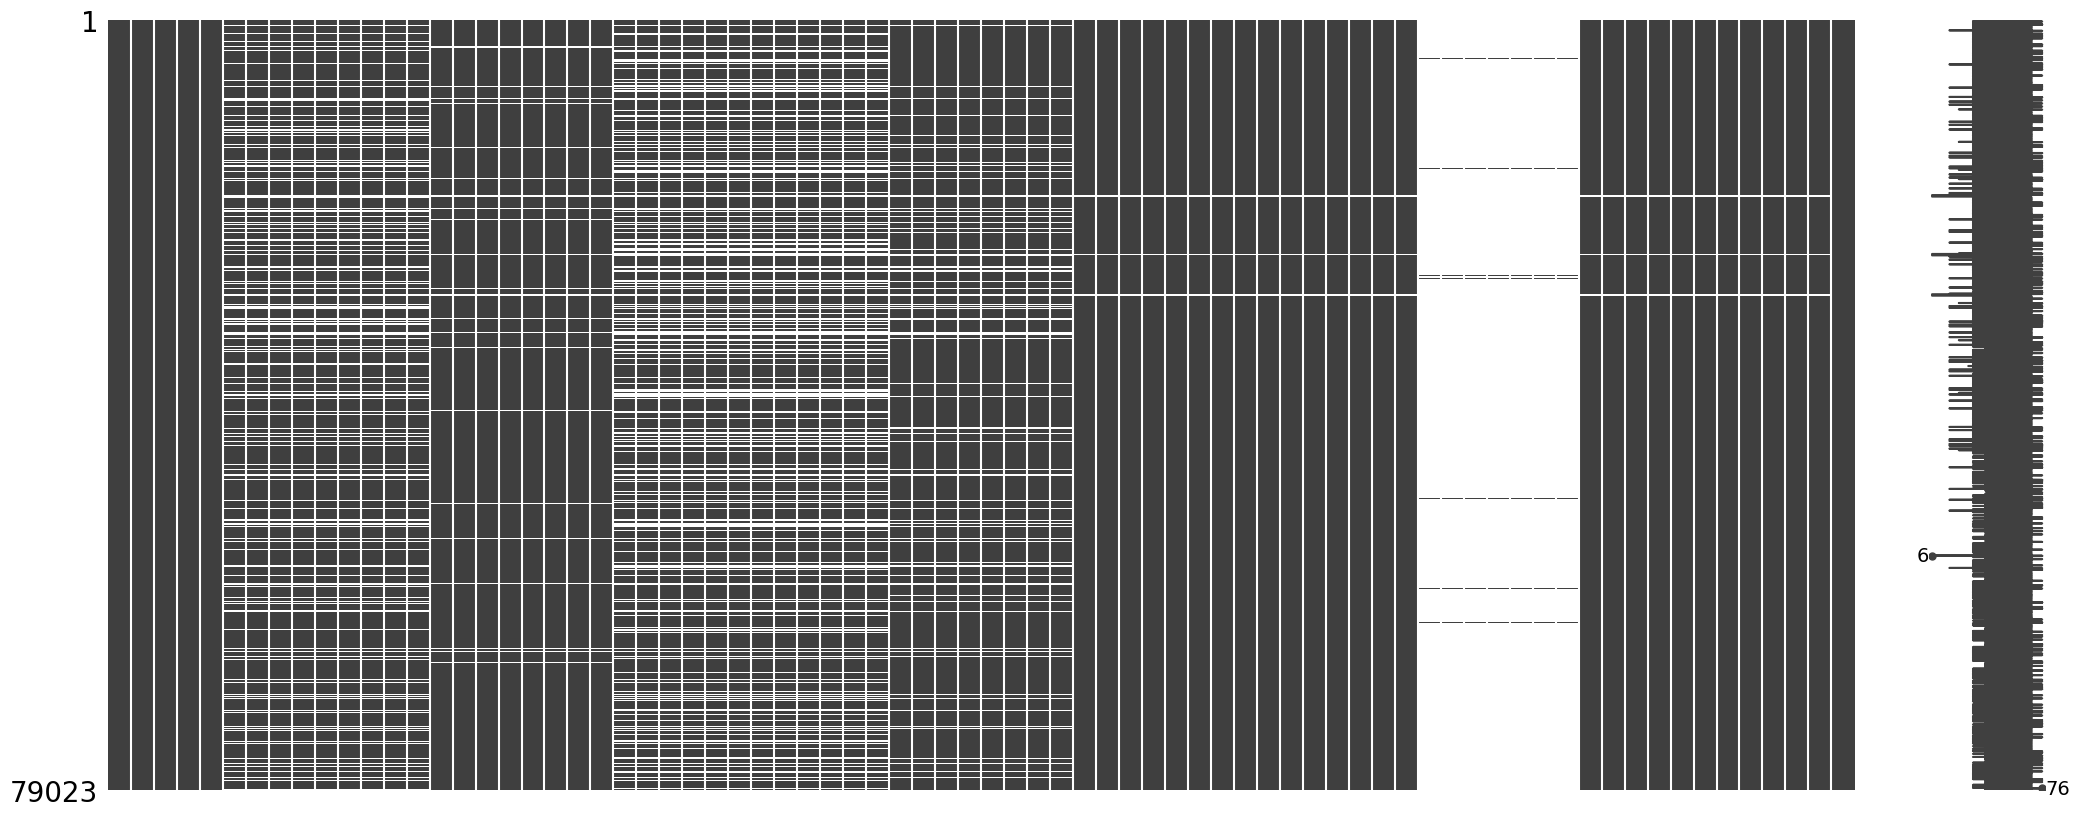

In [13]:
msno.matrix(train)

In [ ]:
s = (train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

In [ ]:
train.columns

In [ ]:
features= ['latitude', 'longitude', 'year', 'week_no',
       'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'CarbonMonoxide_sensor_zenith_angle',
       'CarbonMonoxide_solar_azimuth_angle',
       'CarbonMonoxide_solar_zenith_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_stratospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density',
       'NitrogenDioxide_tropopause_pressure',
       'NitrogenDioxide_absorbing_aerosol_index',
       'NitrogenDioxide_cloud_fraction', 'NitrogenDioxide_sensor_altitude',
       'NitrogenDioxide_sensor_azimuth_angle',
       'NitrogenDioxide_sensor_zenith_angle',
       'NitrogenDioxide_solar_azimuth_angle',
       'NitrogenDioxide_solar_zenith_angle',
       'Formaldehyde_tropospheric_HCHO_column_number_density',
       'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
       'Formaldehyde_HCHO_slant_column_number_density',
       'Formaldehyde_cloud_fraction', 'Formaldehyde_solar_zenith_angle',
       'Formaldehyde_solar_azimuth_angle', 'Formaldehyde_sensor_zenith_angle',
       'Formaldehyde_sensor_azimuth_angle',
       'UvAerosolIndex_absorbing_aerosol_index',
       'UvAerosolIndex_sensor_altitude', 'UvAerosolIndex_sensor_azimuth_angle',
       'UvAerosolIndex_sensor_zenith_angle',
       'UvAerosolIndex_solar_azimuth_angle',
       'UvAerosolIndex_solar_zenith_angle', 'Ozone_O3_column_number_density',
       'Ozone_O3_column_number_density_amf',
       'Ozone_O3_slant_column_number_density',
       'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
       'Ozone_sensor_azimuth_angle', 'Ozone_sensor_zenith_angle',
       'Ozone_solar_azimuth_angle', 'Ozone_solar_zenith_angle',
       'UvAerosolLayerHeight_aerosol_height',
       'UvAerosolLayerHeight_aerosol_pressure',
       'UvAerosolLayerHeight_aerosol_optical_depth',
       'UvAerosolLayerHeight_sensor_zenith_angle',
       'UvAerosolLayerHeight_sensor_azimuth_angle',
       'UvAerosolLayerHeight_solar_azimuth_angle',
       'UvAerosolLayerHeight_solar_zenith_angle', 'Cloud_cloud_fraction',
       'Cloud_cloud_top_pressure', 'Cloud_cloud_top_height',
       'Cloud_cloud_base_pressure', 'Cloud_cloud_base_height',
       'Cloud_cloud_optical_depth', 'Cloud_surface_albedo',
       'Cloud_sensor_azimuth_angle', 'Cloud_sensor_zenith_angle',
       'Cloud_solar_azimuth_angle', 'Cloud_solar_zenith_angle']

In [ ]:
target=['emission']

In [ ]:
X=train[features]
y=train[target]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_X,val_X,train_y,val_y=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values=np.nan, strategy='mean')
train_X=imputer.fit_transform(train_X)
val_X=imputer.transform(val_X)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

In [ ]:
from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin

In [ ]:
seed=2
def objective(params):
    est=int(params['n_estimators'])
    md=int(params['max_depth'])
    msl=int(params['min_samples_leaf'])
    mss=int(params['min_samples_split'])
    model=RandomForestRegressor(n_estimators=est,max_depth=md,min_samples_leaf=msl,min_samples_split=mss)
    model.fit(train_X,train_y)
    pred=model.predict(val_X)
    score=mean_squared_error(val_y,pred)
    return score

In [ ]:
def optimize(trial):
    params={'n_estimators':hp.uniform('n_estimators',10,50),
           'max_depth':hp.uniform('max_depth',5,20),
           'min_samples_leaf':hp.uniform('min_samples_leaf',1,5),
           'min_samples_split':hp.uniform('min_samples_split',2,6)}
    best=fmin(fn=objective,space=params,algo=tpe.suggest,trials=trial,max_evals=50, rstate=np.random.default_rng(seed))
    return best

In [ ]:
trial=Trials()
best=optimize(trial)

In [ ]:
print(best)

In [ ]:
model=RandomForestRegressor(random_state = 42,max_depth=20, min_samples_leaf= 5, min_samples_split= 4, n_estimators=49)

In [ ]:
model.fit(train_X,train_y)

In [ ]:
y_pred = model.predict(test.drop(['ID_LAT_LON_YEAR_WEEK'], axis=1).fillna(0))

In [ ]:
submission = pd.DataFrame({'ID_LAT_LON_YEAR_WEEK': test.ID_LAT_LON_YEAR_WEEK, 'emission': y_pred})
submission.head()

In [ ]:
X_train = train[['latitude',
                 'longitude',
                 'year',
                 'week_no']]
y_train = train["emission"]
feature_names = X_train.columns

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
estimator = Pipeline([("scalar", MinMaxScaler()),
                      ("forest", RandomForestRegressor())])
estimator.fit(X_train, y_train)

In [ ]:
y_pred2 = estimator.predict(X_val)
print("R^2 : ", r2_score(y_val, y_pred2))
print("MAE :", mean_absolute_error(y_val,y_pred2))
print("RMSE:",np.sqrt(mean_squared_error(y_val, y_pred2)))

In [ ]:
X_test = test[[ 'latitude',
                 'longitude',
                 'year',
                 'week_no']]
predictions = estimator.predict(X_test)
output = pd.concat([test["ID_LAT_LON_YEAR_WEEK"], pd.Series(predictions, name="emission")], axis=1)
output.to_csv("/kaggle/working/submission.csv", index=False)